In [1]:
import gower
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN, OPTICS
from hdbscan import HDBSCAN

import warnings
warnings.filterwarnings('ignore')

In [2]:
ls | grep .csv

predict.csv
training.csv


In [3]:
# Creating dataframe for train data.
train_df = pd.read_csv('training.csv')
train_orig_df = train_df.copy()

## Preprocessing

In [4]:
# Getting rid of redundant columns
redundant_cols = ['poster_is_employee', 'poster_is_lead', 'poster_order',
                  'participant1_is_employee', 'participant1_is_lead', 'participant1_order',
                  'participant2_is_employee', 'participant2_is_lead', 'participant2_order',
                  'participant3_is_employee', 'participant3_is_lead', 'participant3_order',
                  'participant4_is_employee', 'participant4_is_lead', 'participant4_order',
                  'participant5_is_employee', 'participant5_is_lead', 'participant5_order',
                  'id', 'participant1_id', 'participant2_id', 'participant3_id',
                  'participant4_id', 'participant5_id', 'owner_id', 'poster_id',
                  'posted_time', 'updated_time', 'age', 'updated_age', 'rank']
useful_cols = [i for i in train_df.columns if i not in redundant_cols]

train_df = train_df[useful_cols]

In [5]:
# Categorizing useful columns
all_cols = [col for col in train_df.columns if col != 'rank']
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]
cat_vector = [col in cat_cols for col in all_cols]

print("Amount of number columns: {}".format(len(num_cols)))
print("Amount of categorical columns: {}".format(len(cat_cols)))
print("cat_vector: {}".format(cat_vector))

Amount of number columns: 22
Amount of categorical columns: 19
cat_vector: [True, True, False, False, False, False, False, False, False, False, False, False, True, False, True, False, True, True, False, True, False, True, True, False, True, False, True, True, False, True, False, True, True, False, True, False, True, True, False, True, False]


## Creating matrix of Gower distances

In [6]:
d = gower.gower_matrix(data_x=train_df, cat_features=cat_vector)
print(d)

[[0.         0.2866772  0.30746377 ... 0.33050266 0.47931537 0.4079055 ]
 [0.2866772  0.         0.11834968 ... 0.5027714  0.56000686 0.4889303 ]
 [0.30746377 0.11834968 0.         ... 0.45814306 0.5155755  0.49294612]
 ...
 [0.33050266 0.5027714  0.45814306 ... 0.         0.25267905 0.12897126]
 [0.47931537 0.56000686 0.5155755  ... 0.25267905 0.         0.17299019]
 [0.4079055  0.4889303  0.49294612 ... 0.12897126 0.17299019 0.        ]]


## DBSCAN

In [7]:
# Using sklearn implementation of DBSCAN algorithm
dbscan = DBSCAN(eps=0.05, min_samples=3, metric='precomputed').fit(d)
print(np.unique(dbscan.labels_))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60]


## OPTICS

In [8]:
# Using sklearn implementation of OPTICS algorithm
optics = OPTICS(min_samples=50, metric='precomputed').fit(d)
print(np.unique(optics.labels_))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


## HDBSCAN

In [9]:
# HDBSCAN algorithm: http://hdbscan.readthedocs.io/en/latest/
hdbscan = HDBSCAN(min_cluster_size=60, min_samples=15, metric='precomputed').fit(d.astype('double'))
print(np.unique(hdbscan.labels_))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


## Visualization

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import animation
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [11]:
def prepare_tsne(n_components, data, labels):
    """
    Function for preparing t-SNE dataframe.
    """
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components, random_state=1).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    # Renaming axes to x, y and z
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = labels
    return df_matrix

def plot_animation(df, label_column, name):
    """
    Function for creating 3d visualization in .gif format.
    """
    def update(num):
        ax.view_init(200, num)

    N = 360 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.get_cmap('tab20b').colors
    
    # Creating plot.
    for label in tsne_3d_df[label_column].unique():
        label_df = tsne_3d_df[tsne_3d_df[label_column] == label]
        sc = ax.scatter(label_df['x'], label_df['y'], label_df['z'], c=np.array(colors[label]).reshape(1, -1),
               label=f"Cluster {label}", s=6, depthshade=True)
    ax.legend(loc='upper right')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    
    # Creating animation for plot.
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('dbscan_results/{}.gif'.format(name), writer='imagemagick')
    plt.show()

In [12]:
# Creating dataframe for future visualization of clustering results.

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(train_df[cat_cols].to_numpy())
rez = encoder.transform(train_df[cat_cols].to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index
new_feature_names = encoder.get_feature_names(cat_cols)
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

train_enc_df = train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

final_enc_df = train_df.copy()
final_enc_df = final_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
final_enc_df = final_enc_df.drop(cat_cols, axis=1)

In [13]:
# Creating t-SNE dataframe
final_enc_df['hdbscan'] = hdbscan.labels_
tsne_3d_df = prepare_tsne(3, train_enc_df, hdbscan.labels_)
tsne_3d_df.head()

,x,y,z,labels
0,4.766263,-4.248677,21.588406,13
1,16.462208,-4.152340,14.711994,10
2,21.226316,-8.690860,-7.752632,11
3,25.231659,9.610816,-9.067855,8
4,24.901371,9.610625,-9.850230,8


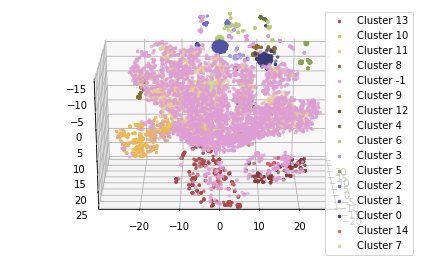

In [14]:
# Creating gif animation
plot_animation(tsne_3d_df, 'labels', 'hdbscan')

In [15]:
# Showing number of news in each cluster
num_clusters = final_enc_df['hdbscan'].nunique()
for i in range(-1, num_clusters-1):
    print("Cluster {} contains {} news.".format(i, len(final_enc_df[final_enc_df['hdbscan'] == i])))

Cluster -1 contains 3748 news.
Cluster 0 contains 120 news.
Cluster 1 contains 118 news.
Cluster 2 contains 85 news.
Cluster 3 contains 61 news.
Cluster 4 contains 123 news.
Cluster 5 contains 78 news.
Cluster 6 contains 239 news.
Cluster 7 contains 155 news.
Cluster 8 contains 265 news.
Cluster 9 contains 110 news.
Cluster 10 contains 811 news.
Cluster 11 contains 2613 news.
Cluster 12 contains 273 news.
Cluster 13 contains 519 news.
Cluster 14 contains 100 news.


## Seeing clustering results

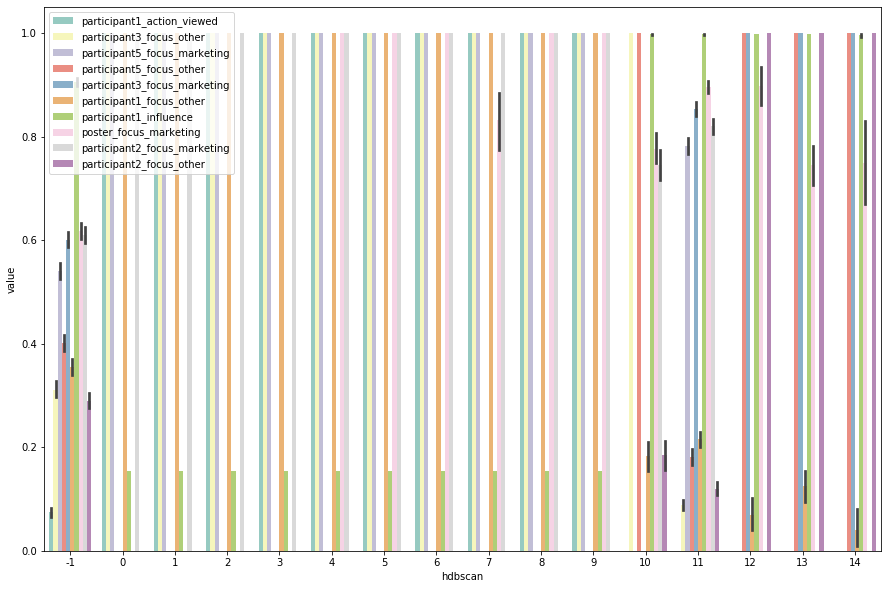

In [16]:
# Seeing K the most different features in clusters
K = 10
drop_columns = ['hdbscan']

scaler = MinMaxScaler()
df = final_enc_df.drop(drop_columns, axis=1)

scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = df.columns
scaled_df['hdbscan'] = hdbscan.labels_

df_mean = scaled_df.groupby('hdbscan').mean().reset_index()
results = pd.DataFrame(columns=['var', 'std'])

for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(K)['var'].values) + ['hdbscan']

# Plot results.
tidy = scaled_df[selected_columns].melt(id_vars='hdbscan')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='hdbscan', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("dbscan_results/hdbscan_results.jpg", dpi=300)

In [17]:
final_enc_df.groupby('hdbscan').describe()

owner_influence                                                  \
                  count      mean       std      min       25%      50%   
hdbscan                                                                   
-1               3748.0  0.689264  0.407507  0.10000  0.100000  0.98088   
 0                120.0  0.103333  0.036515  0.10000  0.100000  0.10000   
 1                118.0  0.999238  0.006249  0.93197  0.999920  0.99992   
 2                 85.0  0.570091  0.415533  0.10000  0.100000  0.91736   
 3                 61.0  0.957088  0.123588  0.50000  0.957260  0.99949   
 4                123.0  0.838200  0.307429  0.10000  0.924665  0.99949   
 5                 78.0  0.928047  0.240751  0.10000  0.999490  0.99949   
 6                239.0  0.700563  0.404906  0.10000  0.100000  0.99655   
 7                155.0  0.260795  0.336267  0.10000  0.100000  0.10000   
 8                265.0  0.997400  0.005876  0.98088  0.999230  0.99973   
 9                110.0  0.956406  0.000256  0.95633  0.956330  0.95633   
 10               811.0  0.798383  0.349138  0.10000  0.907660  0.99882   
 11              2613.0  0.903215  0.253163  0.10000  0.987610  0.99973   
 12               273.0  0.869633  0.284280  0.10000  0.956330  0.99923   
 13               519.0  0.805144  0.340642  0.10000  0.917360  0.99882   
 14               100.0  0.764234  0.371678  0.10000  0.500000  0.99923   

                           number_of_likes                                     \
              75%      max           count      mean       std  min  25%  50%   
hdbscan                                                                         
-1       0.999770  0.99992          3748.0  6.540555  8.240203  0.0  1.0  4.0   
 0       0.100000  0.50000           120.0  0.000000  0.000000  0.0  0.0  0.0   
 1       0.999920  0.99992           118.0  0.000000  0.000000  0.0  0.0  0.0   
 2       0.917360  0.99923            85.0  0.000000  0.000000  0.0  0.0  0.0   
 3       0.999490  0.99980            61.0  0.000000  0.000000  0.0  0.0  0.0   
 4       0.999800  0.99980           123.0  0.000000  0.000000  0.0  0.0  0.0   
 5       0.999783  0.99980            78.0  0.000000  0.000000  0.0  0.0  0.0   
 6       0.999730  0.99980           239.0  0.000000  0.000000  0.0  0.0  0.0   
 7       0.100000  0.99973           155.0  0.000000  0.000000  0.0  0.0  0.0   
 8       0.999800  0.99980           265.0  0.000000  0.000000  0.0  0.0  0.0   
 9       0.956330  0.95726           110.0  0.000000  0.000000  0.0  0.0  0.0   
 10      0.999770  0.99992           811.0  1.241677  0.851021  0.0  0.0  2.0   
 11      0.999800  0.99992          2613.0  5.805205  7.051111  0.0  2.0  3.0   
 12      0.999730  0.99992           273.0  0.062271  0.242091  0.0  0.0  0.0   
 13      0.999730  0.99992           519.0  1.000000  0.000000  1.0  1.0  1.0   
 14      0.999800  0.99992           100.0  0.720000  0.451261  0.0  0.0  1.0   

                   number_of_comments                                          \
         75%   max              count      mean       std  min  25%  50%  75%   
hdbscan                                                                         
-1       9.0  64.0             3748.0  2.143276  5.229815  0.0  0.0  1.0  3.0   
 0       0.0   0.0              120.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
 1       0.0   0.0              118.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
 2       0.0   0.0               85.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
 3       0.0   0.0               61.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
 4       0.0   0.0              123.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
 5       0.0   0.0               78.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
 6       0.0   0.0              239.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
 7       0.0   0.0              155.0  0.000000  0.000000  0.0  0.0  0.0  0.0   
 8       0.0   0.0              265.0  0.000000  0.000000  0.0  0.0  0